In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


wandb experiment

In [ ]:
!pip install wandb -qU
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

sweeps

In [ ]:
!pip install wandb -qU
!pip install tqdm

import wandb
wandb.login()

!pip install transformers spacy torch scikit-learn pandas wandb tqdm

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of packages with specific versions to install
required_packages = [
    "spacy==3.2.0",
    "typer==0.4.0",
    "click==8.0.3",
    "torch",
    "transformers",
    "wandb",
    "scikit-learn",
    "requests==2.24.0"
]

for package in required_packages:
    install(package)

# Download Spacy model
subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])


import os
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import wandb
from tqdm import tqdm

# Initialize spacy and BERT tokenizer
nlp = spacy.load("en_core_web_sm")

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT and TIMEX3 entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })

        data.append((events, timex3s, tlinks, text))
    return data

# Convert BIO data to NLI format
def convert_to_nli_format(extracted_data, window_size=2):
    nli_data = []
    for events, timex3s, tlinks, text in extracted_data:
        doc = nlp(text)
        sentences = list(doc.sents)

        sentence_boundaries = [(sent.start_char, sent.end_char) for sent in sentences]

        for event in events:
            treatment_entity = event["text"]
            treatment_start = event["start"]
            treatment_end = event["end"]

            tlink_map = {t["toID"]: t["type"] for t in tlinks if t["fromID"] == event["id"]}
            tlink_map.update({t["fromID"]: t["type"] for t in tlinks if t["toID"] == event["id"]})

            treatment_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= treatment_start < end)

            for timex in timex3s:
                time_entity = timex["text"]
                time_start = timex["start"]
                time_end = timex["end"]

                time_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= time_start < end)

                selected_indices = set()
                for idx in [treatment_sentence_idx, time_sentence_idx]:
                    start_idx = max(0, idx - window_size)
                    end_idx = min(len(sentences), idx + window_size + 1)
                    selected_indices.update(range(start_idx, end_idx))

                selected_text = " ".join([sentences[i].text for i in sorted(selected_indices)])

                tlink_label = tlink_map.get(timex["id"], "not given")

                if tlink_label == "BEFORE":
                    start_label = "contradiction"
                    end_label = "entailment"
                elif tlink_label == "AFTER":
                    start_label = "entailment"
                    end_label = "contradiction"
                elif tlink_label == "OVERLAP":
                    start_label = "entailment"
                    end_label = "entailment"
                else:
                    start_label = "contradiction"
                    end_label = "contradiction"

                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was started on {time_entity}?", "label": start_label})
                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was ended on {time_entity}?", "label": end_label})

    return pd.DataFrame(nli_data)

# Prepare the dataset for PyTorch DataLoader
def prepare_data_loader(df, batch_size, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []

    label_mapping = {"entailment": 0, "contradiction": 1}

    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['premise'],
            row['hypothesis'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_mapping[row['label']])

    if not input_ids:
        print("Error: input_ids is empty.")
        return None

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return data_loader

# Training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Training loss: {avg_train_loss}')

        eval_loss, accuracy, f1_macro, f1_entailment = evaluate(model, val_loader)
        # Log results to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "eval_loss": eval_loss,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "f1_entailment": f1_entailment
        })

# Evaluation function
def evaluate(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    predictions, true_labels = [], []

    for batch in tqdm(val_loader, desc="Evaluating"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            eval_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(b_labels.tolist())

    avg_eval_loss = eval_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)

    report = classification_report(true_labels, predictions, target_names=["entailment", "contradiction"], output_dict=True)
    f1_macro = report["macro avg"]["f1-score"]
    f1_entailment = report["entailment"]["f1-score"]

    print(f'Validation loss: {avg_eval_loss}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(true_labels, predictions, target_names=["entailment", "contradiction"]))
    return avg_eval_loss, accuracy, f1_macro, f1_entailment

# Main processing function
def main():
    # Sweep configuration
    sweep_config = {
        "method": "bayes",
        "metric": {"name": "f1_macro", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"min": 5e-5, "max": 2e-4},
            "batch_size": {"values": [16, 32]},
            "epochs": {"min": 5, "max": 20},
            "window_size": {"min": 0, "max": 8},
            "model_name": {"values": ["bert-base-uncased", "emilyalsentzer/Bio_ClinicalBERT", "dmis-lab/biobert-base-cased-v1.1", "michiyasunaga/BioLinkBERT-base"]},
            "xml_dir_train": {"values": ["/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/2012-07-15.original-annotation.release"]},
            "xml_dir_eval": {"values": ["/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/ground_truth/merged_xml"]}
        }
    }

    def train_model(config_defaults=None):
        # Initialize wandb
        with wandb.init(config=config_defaults):
            config = wandb.config

            # Load tokenizer and model from local directory
            tokenizer = BertTokenizerFast.from_pretrained(config.model_name)
            model = BertForSequenceClassification.from_pretrained(config.model_name, num_labels=2)

            optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

            xml_dir_train = config.xml_dir_train
            xml_data_train = parse_xml_files(xml_dir_train)
            extracted_data_train = extract_entities(xml_data_train)
            nli_data_train = convert_to_nli_format(extracted_data_train, window_size=config.window_size)

            xml_dir_eval = config.xml_dir_eval
            xml_data_eval = parse_xml_files(xml_dir_eval)
            extracted_data_eval = extract_entities(xml_data_eval)
            nli_data_eval = convert_to_nli_format(extracted_data_eval, window_size=config.window_size)

            # Prepare DataLoader
            train_loader = prepare_data_loader(nli_data_train, config.batch_size, tokenizer)
            val_loader = prepare_data_loader(nli_data_eval, config.batch_size, tokenizer)

            if train_loader is None or val_loader is None:
                print("Error: DataLoader is None.")
                return

            # Train and evaluate the model
            train(model, train_loader, val_loader, optimizer, config.epochs)
            eval_loss, accuracy, f1_macro, f1_entailment = evaluate(model, val_loader)

            # Save final results to wandb
            wandb.log({"eval_loss": eval_loss, "accuracy": accuracy, "f1_macro": f1_macro, "f1_entailment": f1_entailment})

    # Initialize sweep
    sweep_id = wandb.sweep(sweep_config, project="NLI_sweeps_test")

    # Start sweep
    wandb.agent(sweep_id, function=train_model, count=10)

if __name__ == "__main__":
    main()


In [ ]:
import os
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import wandb
from tqdm import tqdm

# Initialize spacy
nlp = spacy.load("en_core_web_sm")

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT and TIMEX3 entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })

        data.append((events, timex3s, tlinks, text))
    return data

# Convert BIO data to NLI format
def convert_to_nli_format(extracted_data, window_size=2):
    nli_data = []
    for events, timex3s, tlinks, text in extracted_data:
        doc = nlp(text)
        sentences = list(doc.sents)

        sentence_boundaries = [(sent.start_char, sent.end_char) for sent in sentences]

        for event in events:
            treatment_entity = event["text"]
            treatment_start = event["start"]
            treatment_end = event["end"]

            tlink_map = {t["toID"]: t["type"] for t in tlinks if t["fromID"] == event["id"]}
            tlink_map.update({t["fromID"]: t["type"] for t in tlinks if t["toID"] == event["id"]})

            treatment_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= treatment_start < end)

            for timex in timex3s:
                time_entity = timex["text"]
                time_start = timex["start"]
                time_end = timex["end"]

                time_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= time_start < end)

                selected_indices = set()
                for idx in [treatment_sentence_idx, time_sentence_idx]:
                    start_idx = max(0, idx - window_size)
                    end_idx = min(len(sentences), idx + window_size + 1)
                    selected_indices.update(range(start_idx, end_idx))

                selected_text = " ".join([sentences[i].text for i in sorted(selected_indices)])

                tlink_label = tlink_map.get(timex["id"], "not given")

                if tlink_label == "BEFORE":
                    start_label = "contradiction"
                    end_label = "entailment"
                elif tlink_label == "AFTER":
                    start_label = "entailment"
                    end_label = "contradiction"
                elif tlink_label == "OVERLAP":
                    start_label = "entailment"
                    end_label = "entailment"
                else:
                    start_label = "contradiction"
                    end_label = "contradiction"

                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was started on {time_entity}?", "label": start_label})
                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was ended on {time_entity}?", "label": end_label})

    return pd.DataFrame(nli_data)

# Prepare the dataset for PyTorch DataLoader
def prepare_data_loader(df, batch_size, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []

    label_mapping = {"entailment": 0, "contradiction": 1}

    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['premise'],
            row['hypothesis'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_mapping[row['label']])

    if not input_ids:
        print("Error: input_ids is empty.")
        return None

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return data_loader

# Training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Training loss: {avg_train_loss}')

        eval_loss, accuracy, macro_f1, entailment_f1 = evaluate(model, val_loader)

        # Log results to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "eval_loss": eval_loss,
            "accuracy": accuracy,
            "macro_avg_f1": macro_f1,
            "entailment_f1": entailment_f1
        })

# Evaluation function
def evaluate(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(val_loader, desc="Evaluating"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            eval_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(b_labels.tolist())

    avg_eval_loss = eval_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    class_report = classification_report(true_labels, predictions, target_names=["entailment", "contradiction"], output_dict=True)
    macro_f1 = class_report["macro avg"]["f1-score"]
    entailment_f1 = class_report["entailment"]["f1-score"]

    print(f'Validation loss: {avg_eval_loss}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(true_labels, predictions, target_names=["entailment", "contradiction"]))

    return avg_eval_loss, accuracy, macro_f1, entailment_f1


# Main processing function
def main(params):
    # Initialize wandb
    wandb.login()  # Ensure you are logged into wandb
    wandb.init(project="NLI_7.29", config=params, name=str(params))
    config = wandb.config

    # Load tokenizer and model from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=2)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    xml_dir_train = config.xml_dir_train
    xml_data_train = parse_xml_files(xml_dir_train)
    extracted_data_train = extract_entities(xml_data_train)
    nli_data_train = convert_to_nli_format(extracted_data_train, window_size=config.window_size)

    xml_dir_eval = config.xml_dir_eval
    xml_data_eval = parse_xml_files(xml_dir_eval)
    extracted_data_eval = extract_entities(xml_data_eval)
    nli_data_eval = convert_to_nli_format(extracted_data_eval, window_size=config.window_size)

    # Prepare DataLoader
    train_loader = prepare_data_loader(nli_data_train, config.batch_size, tokenizer)
    val_loader = prepare_data_loader(nli_data_eval, config.batch_size, tokenizer)

    if train_loader is None or val_loader is None:
        print("Error: DataLoader is None.")
        return

    # Train and evaluate the model
    train(model, train_loader, val_loader, optimizer, config.epochs)
    eval_loss, accuracy, f1_macro, f1_entailment = evaluate(model, val_loader)

    # Save final results to wandb
    wandb.log({"eval_loss": eval_loss, "accuracy": accuracy, "f1_macro": f1_macro, "f1_entailment": f1_entailment})

    # Save results locally
    with open("experiment_results.txt", "a") as f:
        f.write(f"Params: {params}\n")
        f.write(f"Eval Loss: {eval_loss}, Accuracy: {accuracy}, Macro F1: {f1_macro}, Entailment F1: {f1_entailment}\n\n")

if __name__ == "__main__":
    # Hyperparameter grid
    param_grid = {
        "learning_rate": [2e-5,3e-5],
        "batch_size": [16,32],
        "epochs": [10,15,20],
        "window_size": [2,4,6,8,10],
        "model_name": ["bert-base-uncased", "emilyalsentzer/Bio_ClinicalBERT", "dmis-lab/biobert-base-cased-v1.1", "michiyasunaga/BioLinkBERT-base"],
        #  "model_name": ["bert-base-uncased"],
        "xml_dir_train": ["n2c2_2012_train_eval/2012-07-15.original-annotation.release"],
        "xml_dir_eval": ["n2c2_2012_train_eval/ground_truth/merged_xml"]
    }

    # Create combinations of hyperparameters
    from itertools import product
    param_combinations = list(product(*param_grid.values()))

    # Convert combinations to list of dicts
    param_list = []
    for combination in param_combinations:
        param_dict = {key: value for key, value in zip(param_grid.keys(), combination)}
        param_list.append(param_dict)

    # Run experiments for each parameter combination
    for params in param_list:
        main(params)


zoning

In [ ]:
import os
import re
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import wandb
from tqdm import tqdm

# Initialize spacy
nlp = spacy.load("en_core_web_sm")

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT, TIMEX3, and SECTIME entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []
        sectimes = {}

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })
            elif tag.tag == "SECTIME":
                sectimes[tag.attrib["type"]] = {
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                    "type": tag.attrib["type"],
                    "dvalue": tag.attrib["dvalue"]
                }

        data.append((events, timex3s, tlinks, sectimes, text))
    return data

# Function to segment text into paragraphs
def segment_text(text):
    keywords = [
        "History of Present Illness",
        "Brief Hospital Course",
        "HISTORY OF PRESENT ILLNESS",
        "HOSPITAL COURSE"
    ]
    # Use regular expressions to find the positions of the keywords
    pattern = re.compile(rf"\b({'|'.join(re.escape(kw) for kw in keywords)})\b", re.IGNORECASE)
    matches = list(pattern.finditer(text))

    paragraphs = []
    start = 0
    for match in matches:
        end = match.start()
        paragraphs.append(text[start:end].strip())
        start = end
    paragraphs.append(text[start:].strip())

    return paragraphs

# Function to find paragraph index for an event or timex
def find_paragraph_idx(paragraphs, start_pos, text):
    for i, para in enumerate(paragraphs):
        para_start_pos = text.find(para)
        para_end_pos = para_start_pos + len(para)
        if para_start_pos <= start_pos < para_end_pos:
            return i
    return -1

# Convert BIO data to NLI format
def convert_to_nli_format(extracted_data, window_size=2):
    nli_data = []
    for events, timex3s, tlinks, sectimes, text in extracted_data:
        paragraphs = segment_text(text)
        doc = nlp(text)
        sentences = list(doc.sents)

        sentence_boundaries = [(sent.start_char, sent.end_char) for sent in sentences]

        for event in events:
            treatment_entity = event["text"]
            treatment_start = event["start"]
            treatment_end = event["end"]
            treatment_paragraph_idx = find_paragraph_idx(paragraphs, treatment_start, text)

            tlink_map = {t["toID"]: t["type"] for t in tlinks if t["fromID"] == event["id"]}
            tlink_map.update({t["fromID"]: t["type"] for t in tlinks if t["toID"] == event["id"]})

            treatment_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= treatment_start < end)

            # Select time expressions in the same paragraph as the treatment or the special ones
            relevant_timex3s = [
                timex for timex in timex3s
                if find_paragraph_idx(paragraphs, timex["start"], text) == treatment_paragraph_idx
            ] + [sectimes.get("ADMISSION"), sectimes.get("DISCHARGE")]

            for timex in relevant_timex3s:
                if timex is None:
                    continue
                time_entity = timex["text"]
                time_start = timex["start"]
                time_end = timex["end"]

                time_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= time_start < end)

                selected_indices = set()
                for idx in [treatment_sentence_idx, time_sentence_idx]:
                    start_idx = max(0, idx - window_size)
                    end_idx = min(len(sentences), idx + window_size + 1)
                    selected_indices.update(range(start_idx, end_idx))

                selected_text = " ".join([sentences[i].text for i in sorted(selected_indices)])

                tlink_label = tlink_map.get(timex["id"], "not given")

                if tlink_label == "BEFORE":
                    start_label = "contradiction"
                    end_label = "entailment"
                elif tlink_label == "AFTER":
                    start_label = "entailment"
                    end_label = "contradiction"
                elif tlink_label == "OVERLAP":
                    start_label = "entailment"
                    end_label = "entailment"
                else:
                    start_label = "contradiction"
                    end_label = "contradiction"

                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was started on {time_entity}?", "label": start_label})
                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was ended on {time_entity}?", "label": end_label})

    return pd.DataFrame(nli_data)

# Prepare the dataset for PyTorch DataLoader
def prepare_data_loader(df, batch_size, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []

    label_mapping = {"entailment": 0, "contradiction": 1}

    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['premise'],
            row['hypothesis'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_mapping[row['label']])

    if not input_ids:
        print("Error: input_ids is empty.")
        return None

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return data_loader

# Training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Training loss: {avg_train_loss}')

        eval_loss, accuracy, macro_f1, entailment_f1 = evaluate(model, val_loader)

        # Log results to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "eval_loss": eval_loss,
            "accuracy": accuracy,
            "macro_avg_f1": macro_f1,
            "entailment_f1": entailment_f1
        })

# Evaluation function
def evaluate(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(val_loader, desc="Evaluating"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            eval_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(b_labels.tolist())

    avg_eval_loss = eval_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    class_report = classification_report(true_labels, predictions, target_names=["entailment", "contradiction"], output_dict=True)
    macro_f1 = class_report["macro avg"]["f1-score"]
    entailment_f1 = class_report["entailment"]["f1-score"]

    print(f'Validation loss: {avg_eval_loss}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(true_labels, predictions, target_names=["entailment", "contradiction"]))

    return avg_eval_loss, accuracy, macro_f1, entailment_f1

# Main processing function
def main(params):
    # Initialize wandb
    wandb.login()  # Ensure you are logged into wandb
    wandb.init(project="temporal-linking-classification", config=params, name=str(params)+"_zoning")
    config = wandb.config

    # Load tokenizer and model from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=2)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    xml_dir_train = config.xml_dir_train
    xml_data_train = parse_xml_files(xml_dir_train)
    extracted_data_train = extract_entities(xml_data_train)
    nli_data_train = convert_to_nli_format(extracted_data_train, window_size=config.window_size)

    xml_dir_eval = config.xml_dir_eval
    xml_data_eval = parse_xml_files(xml_dir_eval)
    extracted_data_eval = extract_entities(xml_data_eval)
    nli_data_eval = convert_to_nli_format(extracted_data_eval, window_size=config.window_size)

    # Prepare DataLoader
    train_loader = prepare_data_loader(nli_data_train, config.batch_size, tokenizer)
    val_loader = prepare_data_loader(nli_data_eval, config.batch_size, tokenizer)

    if train_loader is None or val_loader is None:
        print("Error: DataLoader is None.")
        return

    # Train and evaluate the model
    train(model, train_loader, val_loader, optimizer, config.epochs)
    eval_loss, accuracy, f1_macro, f1_entailment = evaluate(model, val_loader)

    # Save results to wandb
    wandb.log({"eval_loss": eval_loss, "accuracy": accuracy, "f1_macro": f1_macro, "f1_entailment": f1_entailment})

    # Save results locally
    with open("experiment_results.txt", "a") as f:
        f.write(f"Params: {params}\n")
        f.write(f"Eval Loss: {eval_loss}, Accuracy: {accuracy}, F1 Macro: {f1_macro}, F1 Entailment: {f1_entailment}\n\n")

if __name__ == "__main__":
    # Hyperparameter grid
    param_grid = {
        "learning_rate": [2e-5, 3e-5, 5e-5],
        "batch_size": [16, 32],
        "epochs": [3, 4],
        "window_size": [2, 3],
        "model_name": ["bert-base-uncased", "emilyalsentzer/Bio_ClinicalBERT", "dmis-lab/biobert-base-cased-v1.1", "michiyasunaga/BioLinkBERT-base"],
        "xml_dir_train": ["/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/2012-07-15.original-annotation.release"],
        "xml_dir_eval": ["/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/ground_truth/merged_xml"]
    }

    # Create combinations of hyperparameters
    from itertools import product
    param_combinations = list(product(*param_grid.values()))

    # Convert combinations to list of dicts
    param_list = []
    for combination in param_combinations:
        param_dict = {key: value for key, value in zip(param_grid.keys(), combination)}
        param_list.append(param_dict)

    # Run experiments for each parameter combination
    for params in param_list:
        main(params)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error parsing 807.xml, skipping...
Error parsing 547.xml, skipping...
Error parsing 422.xml, skipping...
Error parsing 382.xml, skipping...
Error parsing 272.xml, skipping...
Error parsing 23.xml, skipping...
Error parsing 152.xml, skipping...
Error parsing 143.xml, skipping...
Error parsing 397.xml, skipping...
Error parsing 527.xml, skipping...
Error parsing 627.xml, skipping...
Error parsing 53.xml, skipping...
Error parsing 687.xml, skipping...
Error parsing 802.xml, skipping...
Epoch 1/3


Training:   5%|▌         | 171/3343 [04:16<1:19:13,  1.50s/it]


KeyboardInterrupt: 

In [2]:
import os
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report

# Initialize spacy and BERT tokenizer
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT and TIMEX3 entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })

        data.append((events, timex3s, tlinks, text))
    return data

# Convert BIO data to NLI format
def convert_to_nli_format(extracted_data, window_size=2):
    nli_data = []
    for events, timex3s, tlinks, text in extracted_data:
        doc = nlp(text)
        sentences = list(doc.sents)

        sentence_boundaries = [(sent.start_char, sent.end_char) for sent in sentences]

        for event in events:
            treatment_entity = event["text"]
            treatment_start = event["start"]
            treatment_end = event["end"]

            # Debugging: Print event information
            # print(f"Event: {event}")

            tlink_map = {t["toID"]: t["type"] for t in tlinks if t["fromID"] == event["id"]}
            tlink_map.update({t["fromID"]: t["type"] for t in tlinks if t["toID"] == event["id"]})

            # Debugging: Print TLINK map
            # print(f"TLINK map: {tlink_map}")

            treatment_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= treatment_start < end)

            for timex in timex3s:
                time_entity = timex["text"]
                time_start = timex["start"]
                time_end = timex["end"]

                time_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= time_start < end)

                selected_indices = set()
                for idx in [treatment_sentence_idx, time_sentence_idx]:
                    start_idx = max(0, idx - window_size)
                    end_idx = min(len(sentences), idx + window_size + 1)
                    selected_indices.update(range(start_idx, end_idx))

                selected_text = " ".join([sentences[i].text for i in sorted(selected_indices)])

                tlink_label = tlink_map.get(timex["id"], "not given")
                # Debugging: Print TLINK label and corresponding entities
                # print(f"Timex: {timex}, TLINK label: {tlink_label}")

                if tlink_label == "BEFORE":
                    start_label = "contradiction"
                    end_label = "entailment"
                elif tlink_label == "AFTER":
                    start_label = "entailment"
                    end_label = "contradiction"
                elif tlink_label == "OVERLAP":
                    start_label = "entailment"
                    end_label = "entailment"
                else:
                    start_label = "contradiction"
                    end_label = "contradiction"

                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was started on {time_entity}?", "label": start_label})
                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was ended on {time_entity}?", "label": end_label})

    return pd.DataFrame(nli_data)

# Prepare the dataset for PyTorch DataLoader
def prepare_data_loader(df, batch_size):
    input_ids = []
    attention_masks = []
    labels = []

    label_mapping = {"entailment": 0, "contradiction": 1}

    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['premise'],
            row['hypothesis'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_mapping[row['label']])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return data_loader

# Training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        total_loss = 0
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Training loss: {avg_train_loss}')

        evaluate(model, val_loader)

# Evaluation function
def evaluate(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            eval_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(b_labels.tolist())

    avg_eval_loss = eval_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Validation loss: {avg_eval_loss}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(true_labels, predictions, target_names=["entailment", "contradiction"]))

# Main processing
xml_dir_train = "/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/2012-07-06.release-fix"
xml_dir_test = "/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/ground_truth/merged_xml"
xml_data_train = parse_xml_files(xml_dir_train)

xml_data_test = parse_xml_files(xml_dir_test)


extracted_data_train = extract_entities(xml_data_train)
extracted_data_test = extract_entities(xml_data_test)

nli_data_train = convert_to_nli_format(extracted_data_train, window_size=2)
nli_data_test = convert_to_nli_format(extracted_data_test, window_size=2)


# Analysis: Count the number of samples for each label
label_counts = nli_data_test['label'].value_counts()
print("Label counts in the NLI dataset:")
print(label_counts)

# Print an example sample
print("\nExample NLI sample:")
pd.set_option('display.max_colwidth', None)
print(nli_data_test.iloc[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Error parsing 807.xml, skipping...
Error parsing 422.xml, skipping...
Error parsing 397.xml, skipping...
Error parsing 527.xml, skipping...
Error parsing 627.xml, skipping...
Error parsing 53.xml, skipping...
Error parsing 687.xml, skipping...
Error parsing 802.xml, skipping...
Label counts in the NLI dataset:
label
contradiction    76887
entailment        3503
Name: count, dtype: int64

Example NLI sample:
premise       On arrival to Shirley , temperature was 101.2 .\n CT abd showed an 8 mm right proximal ureteral stone with right-sided hydronephrosis and inflammatory stranding , in addition to pyelonephritis of the left kidney without left sided hydronephrosis .\n Labs were remarkable for wbc 23.5 w/ 1% bands which decreased to 14 today but now w/ 15% bands on vanc ( h/o MRSA urosepsis ) and gent ( mult drug allergies ) .\n AG on admission 18 ( bicarb 17 , down from 23 on a previous admission ) , down to AG 15 this AM .\n ABG prior to transfer ( on room air ) :\n7.43/24/69 w/ lactate

In [ ]:
# Analysis: Count the number of samples for each label
label_counts = nli_data_train['label'].value_counts()
print("Label counts in the NLI dataset:")
print(label_counts)

# Print an example sample
print("\nExample NLI sample:")
pd.set_option('display.max_colwidth', None)
print(nli_data_train.iloc[0])

Label counts in the NLI dataset:
label
contradiction    41159
entailment        2255
Name: count, dtype: int64

Example NLI sample:
premise       HOSPITAL COURSE :\nOn the day of admission , the patient went to the Operating Room and underwent a minimally invasive\nmitral valve repair .\n He tolerated this procedure well .\n The patient was brought to the cardiothoracic Intensive Care Unit in stable condition on minimal pressor support .\n He was successfully weaned off this support .\n The patient was fully weaned from ventilatory support secondary to a persistent acidemia .\n This was treated with sodium bicarbonate and a Swan-Ganz was placed to provide close hemodynamic monitoring .\n The patient was found to have stable hemodynamics with appropriate mixed venous saturations in the 70% range .\n The patient was corrected to a normal pH of 7.41 by the first postoperative night and remained stable .\n He was then weaned off of ventilatory support and was successfully extubated .\n The

In [ ]:
print("\nExample NLI sample:")
pd.set_option('display.max_colwidth', None)
print(nli_data_test.iloc[10:20])


Example NLI sample:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# Split the data into train and validation sets
train_df,__= train_test_split(nli_data_train, test_size=0.0, stratify=nli_data_train['label'])
val_df,__= train_test_split(nli_data_test, test_size=0.0, stratify=nli_data_test['label'])
# Prepare DataLoader
batch_size = 32
train_loader = prepare_data_loader(train_df, batch_size)
val_loader = prepare_data_loader(val_df, batch_size)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Train and evaluate the model
train(model, train_loader, val_loader, optimizer, epochs=3)

NameError: name 'nli_data' is not defined

error analysis

In [ ]:
import os
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import wandb
from tqdm import tqdm

# Initialize spacy
nlp = spacy.load("en_core_web_sm")

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT and TIMEX3 entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })

        data.append((events, timex3s, tlinks, text))
    return data

# Convert BIO data to NLI format
def convert_to_nli_format(extracted_data, window_size=2):
    nli_data = []
    for events, timex3s, tlinks, text in extracted_data:
        doc = nlp(text)
        sentences = list(doc.sents)

        sentence_boundaries = [(sent.start_char, sent.end_char) for sent in sentences]

        for event in events:
            treatment_entity = event["text"]
            treatment_start = event["start"]
            treatment_end = event["end"]

            tlink_map = {t["toID"]: t["type"] for t in tlinks if t["fromID"] == event["id"]}
            tlink_map.update({t["fromID"]: t["type"] for t in tlinks if t["toID"] == event["id"]})

            treatment_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= treatment_start < end)

            for timex in timex3s:
                time_entity = timex["text"]
                time_start = timex["start"]
                time_end = timex["end"]

                time_sentence_idx = next(i for i, (start, end) in enumerate(sentence_boundaries) if start <= time_start < end)

                selected_indices = set()
                for idx in [treatment_sentence_idx, time_sentence_idx]:
                    start_idx = max(0, idx - window_size)
                    end_idx = min(len(sentences), idx + window_size + 1)
                    selected_indices.update(range(start_idx, end_idx))

                selected_text = " ".join([sentences[i].text for i in sorted(selected_indices)])

                tlink_label = tlink_map.get(timex["id"], "not given")

                if tlink_label == "BEFORE":
                    start_label = "contradiction"
                    end_label = "entailment"
                elif tlink_label == "AFTER":
                    start_label = "entailment"
                    end_label = "contradiction"
                elif tlink_label == "OVERLAP":
                    start_label = "entailment"
                    end_label = "entailment"
                else:
                    start_label = "contradiction"
                    end_label = "contradiction"

                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was started on {time_entity}?", "label": start_label})
                nli_data.append({"premise": selected_text, "hypothesis": f"{treatment_entity} was ended on {time_entity}?", "label": end_label})

    return pd.DataFrame(nli_data)

# Prepare the dataset for PyTorch DataLoader
def prepare_data_loader(df, batch_size, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []

    label_mapping = {"entailment": 0, "contradiction": 1}

    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['premise'],
            row['hypothesis'],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label_mapping[row['label']])

    if not input_ids:
        print("Error: input_ids is empty.")
        return None

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return data_loader

# Training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Training loss: {avg_train_loss}')

        eval_loss, accuracy, macro_f1, entailment_f1 = evaluate(model, val_loader)

        # Log results to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "eval_loss": eval_loss,
            "accuracy": accuracy,
            "macro_avg_f1": macro_f1,
            "entailment_f1": entailment_f1
        })

def error_analysis(model, val_loader, tokenizer, error_analysis_file):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    incorrect_samples = []  # 存储错误分类的样本

    for batch in tqdm(val_loader, desc="Error Analysis"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1)

            # 记录错误分类的样本
            for i in range(len(batch_predictions)):
                if batch_predictions[i].item() != b_labels[i].item():
                    incorrect_samples.append({
                        "premise": tokenizer.decode(b_input_ids[i], skip_special_tokens=True),
                        "hypothesis": tokenizer.decode(b_input_ids[i], skip_special_tokens=True),
                        "true_label": b_labels[i].item(),
                        "predicted_label": batch_predictions[i].item()
                    })

    # 保存错误分析到文件
    if error_analysis_file:
        with open(error_analysis_file, 'w') as f:
            for sample in incorrect_samples:
                f.write(f"Premise: {sample['premise']}\n")
                f.write(f"Hypothesis: {sample['hypothesis']}\n")
                f.write(f"True Label: {sample['true_label']}\n")
                f.write(f"Predicted Label: {sample['predicted_label']}\n")
                f.write("\n")

    print(f"Saved {len(incorrect_samples)} incorrect samples to {error_analysis_file}")


# Evaluation function
def evaluate(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(val_loader, desc="Evaluating"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            eval_loss += loss.item()
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            true_labels.extend(b_labels.tolist())

    avg_eval_loss = eval_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    class_report = classification_report(true_labels, predictions, target_names=["entailment", "contradiction"], output_dict=True)
    macro_f1 = class_report["macro avg"]["f1-score"]
    entailment_f1 = class_report["entailment"]["f1-score"]

    print(f'Validation loss: {avg_eval_loss}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(true_labels, predictions, target_names=["entailment", "contradiction"]))

    return avg_eval_loss, accuracy, macro_f1, entailment_f1


# Main processing function
def main(params):
    # Initialize wandb
    wandb.login()  # Ensure you are logged into wandb
    wandb.init(project="NLI_7.29", config=params, name=str(params))
    config = wandb.config

    # Load tokenizer and model from Hugging Face
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=2)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    xml_dir_train = config.xml_dir_train
    xml_data_train = parse_xml_files(xml_dir_train)
    extracted_data_train = extract_entities(xml_data_train)
    nli_data_train = convert_to_nli_format(extracted_data_train, window_size=config.window_size)

    xml_dir_eval = config.xml_dir_eval
    xml_data_eval = parse_xml_files(xml_dir_eval)
    extracted_data_eval = extract_entities(xml_data_eval)
    nli_data_eval = convert_to_nli_format(extracted_data_eval, window_size=config.window_size)

    # Prepare DataLoader
    train_loader = prepare_data_loader(nli_data_train, config.batch_size, tokenizer)
    val_loader = prepare_data_loader(nli_data_eval, config.batch_size, tokenizer)

    if train_loader is None or val_loader is None:
        print("Error: DataLoader is None.")
        return

    # Train the model
    train(model, train_loader, val_loader, optimizer, config.epochs)

    # Final evaluation without error analysis
    eval_loss, accuracy, f1_macro, f1_entailment = evaluate(model, val_loader)

    # Save final results to wandb
    wandb.log({"eval_loss": eval_loss, "accuracy": accuracy, "f1_macro": f1_macro, "f1_entailment": f1_entailment})

    # Save results locally
    with open("experiment_results.txt", "a") as f:
        f.write(f"Params: {params}\n")
        f.write(f"Eval Loss: {eval_loss}, Accuracy: {accuracy}, Macro F1: {f1_macro}, Entailment F1: {f1_entailment}\n\n")

    # Perform error analysis after all epochs are completed
    error_analysis_file = "error_analysis.txt"  # Specify the error analysis file path
    error_analysis(model, val_loader, tokenizer, error_analysis_file)

if __name__ == "__main__":
    # Hyperparameter grid
    param_grid = {
        "learning_rate": [7e-5, 3e-5],
        "batch_size": [16],
        "epochs": [15],
        "window_size": [2],
        "model_name": ["michiyasunaga/BioLinkBERT-base"],
        #  "model_name": ["bert-base-uncased"],
        "xml_dir_train": ["data/n2c2_2012_train_eval/2012-07-15.original-annotation.release"],
        "xml_dir_eval": ["data/n2c2_2012_train_eval/ground_truth/merged_xml"]
    }

    # Create combinations of hyperparameters
    from itertools import product
    param_combinations = list(product(*param_grid.values()))

    # Convert combinations to list of dicts
    param_list = []
    for combination in param_combinations:
        param_dict = {key: value for key, value in zip(param_grid.keys(), combination)}
        param_list.append(param_dict)

    # Run experiments for each parameter combination
    for params in param_list:
        main(params)


data analysis

Error parsing 397.xml, skipping...
Error parsing 527.xml, skipping...
Error parsing 627.xml, skipping...
Error parsing 53.xml, skipping...
Error parsing 687.xml, skipping...
Error parsing 802.xml, skipping...


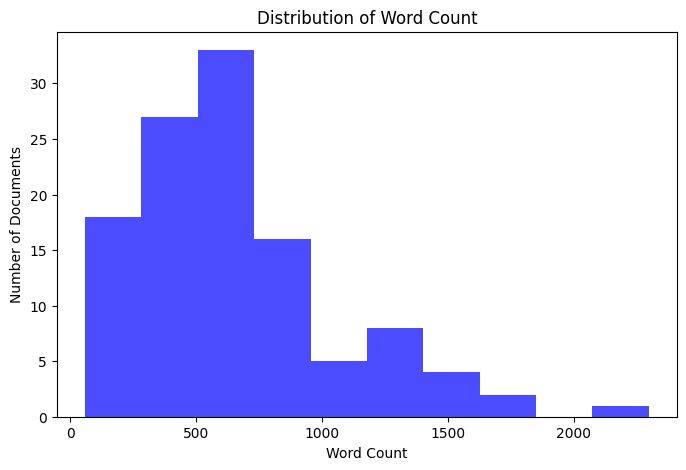

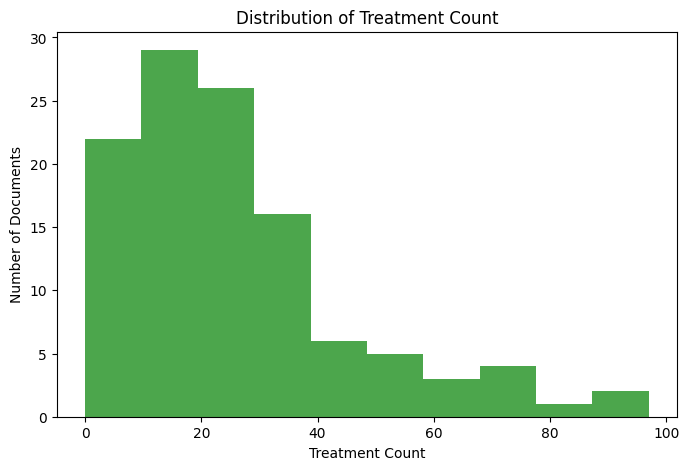

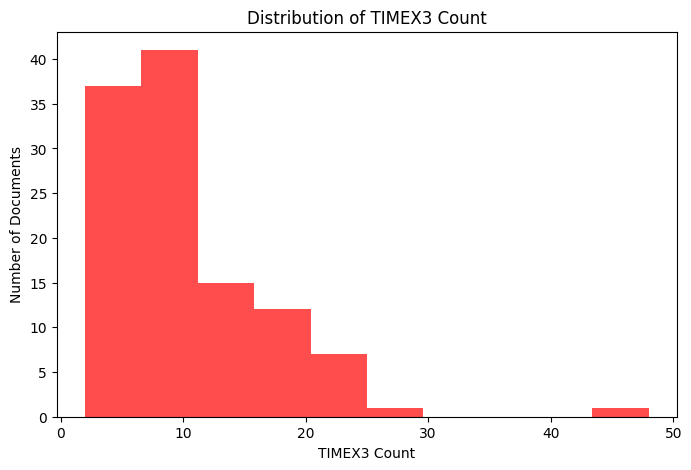

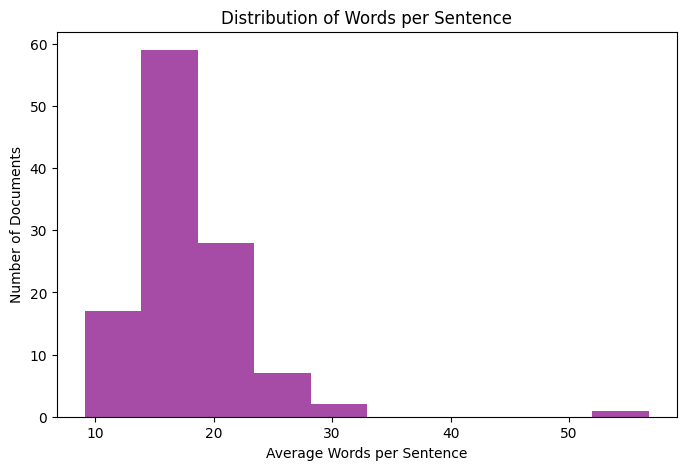

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import xml.etree.ElementTree as ET
import spacy
from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Initialize spacy
nlp = spacy.load("en_core_web_sm")

# Function to read and parse XML files
def parse_xml_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            try:
                tree = ET.parse(os.path.join(directory, filename))
                root = tree.getroot()
                text_content = root.find("TEXT").text
                data.append((root, text_content))
            except ET.ParseError:
                print(f"Error parsing {filename}, skipping...")
    return data

# Function to extract EVENT, TIMEX3, and SECTIME entities
def extract_entities(xml_data):
    data = []
    for entry, text in xml_data:
        events = []
        timex3s = []
        tlinks = []
        sectimes = {}

        for tag in entry.find("TAGS"):
            if tag.tag == "EVENT" and tag.attrib["type"] == "TREATMENT":
                events.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TIMEX3" and tag.attrib["type"] == "DATE":
                timex3s.append({
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                })
            elif tag.tag == "TLINK":
                tlinks.append({
                    "fromID": tag.attrib["fromID"],
                    "toID": tag.attrib["toID"],
                    "type": tag.attrib["type"]
                })
            elif tag.tag == "SECTIME":
                sectimes[tag.attrib["type"]] = {
                    "id": tag.attrib["id"],
                    "text": tag.attrib["text"],
                    "start": int(tag.attrib["start"]),
                    "end": int(tag.attrib["end"]),
                    "type": tag.attrib["type"],
                    "dvalue": tag.attrib["dvalue"]
                }

        data.append((events, timex3s, tlinks, sectimes, text))
    return data

# Function to segment text into paragraphs
def segment_text(text):
    keywords = [
        "History of Present Illness",
        "Brief Hospital Course",
        "HISTORY OF PRESENT ILLNESS",
        "HOSPITAL COURSE"
    ]
    # Use regular expressions to find the positions of the keywords
    pattern = re.compile(rf"\b({'|'.join(re.escape(kw) for kw in keywords)})\b", re.IGNORECASE)
    matches = list(pattern.finditer(text))

    paragraphs = []
    start = 0
    for match in matches:
        end = match.start()
        paragraphs.append(text[start:end].strip())
        start = end
    paragraphs.append(text[start:].strip())

    return paragraphs
import matplotlib.pyplot as plt
import numpy as np

# Function to analyze the documents
def analyze_documents(extracted_data):
    word_counts = []
    treatment_counts = []
    timex3_counts = []
    words_per_sentence_counts = []

    for events, timex3s, _, _, text in extracted_data:
        # Count words in the document
        word_count = len(text.split())
        word_counts.append(word_count)

        # Count the number of treatments in the document
        treatment_count = len(events)
        treatment_counts.append(treatment_count)

        # Count the number of TIMEX3 entities in the document
        timex3_count = len(timex3s)
        timex3_counts.append(timex3_count)

        # Count words per sentence in the document
        doc = nlp(text)
        sentence_word_counts = [len(sent.text.split()) for sent in doc.sents]
        words_per_sentence_counts.append(np.mean(sentence_word_counts) if sentence_word_counts else 0)

    return word_counts, treatment_counts, timex3_counts, words_per_sentence_counts

# Function to create individual bar charts for each metric
def plot_individual_charts(word_counts, treatment_counts, timex3_counts, words_per_sentence_counts):
    # Word Count Chart
    plt.figure(figsize=(8, 5))
    plt.hist(word_counts, bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Word Count')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Documents')
    plt.show()

    # Treatment Count Chart
    plt.figure(figsize=(8, 5))
    plt.hist(treatment_counts, bins=10, color='green', alpha=0.7)
    plt.title('Distribution of Treatment Count')
    plt.xlabel('Treatment Count')
    plt.ylabel('Number of Documents')
    plt.show()

    # TIMEX3 Count Chart
    plt.figure(figsize=(8, 5))
    plt.hist(timex3_counts, bins=10, color='red', alpha=0.7)
    plt.title('Distribution of TIMEX3 Count')
    plt.xlabel('TIMEX3 Count')
    plt.ylabel('Number of Documents')
    plt.show()

    # Words per Sentence Chart
    plt.figure(figsize=(8, 5))
    plt.hist(words_per_sentence_counts, bins=10, color='purple', alpha=0.7)
    plt.title('Distribution of Words per Sentence')
    plt.xlabel('Average Words per Sentence')
    plt.ylabel('Number of Documents')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Assuming you have already parsed XML files and extracted the entities using the provided code
    xml_dir = '/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/ground_truth/merged_xml'

    xml_data = parse_xml_files(xml_dir)
    extracted_data = extract_entities(xml_data)

    # Analyze the documents
    word_counts, treatment_counts, timex3_counts, words_per_sentence_counts = analyze_documents(extracted_data)

    # Plot the analysis
    plot_individual_charts(word_counts, treatment_counts, timex3_counts, words_per_sentence_counts)




Error parsing 397.xml, skipping...
Error parsing 527.xml, skipping...
Error parsing 627.xml, skipping...
Error parsing 53.xml, skipping...
Error parsing 687.xml, skipping...
Error parsing 802.xml, skipping...


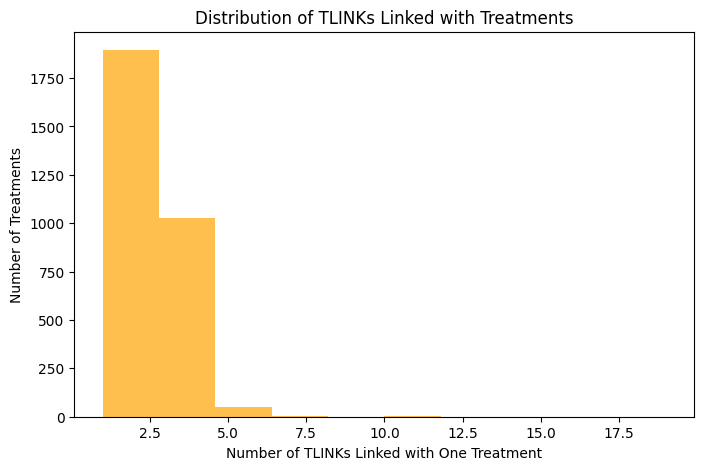

In [5]:
import matplotlib.pyplot as plt

# Function to analyze TLINKs linked with treatments
def analyze_tlink_per_treatment(extracted_data):
    tlink_per_treatment_counts = []

    for events, _, tlinks, _, _ in extracted_data:
        # Dictionary to track how many TLINKs are linked with each treatment
        tlink_count_dict = {event['id']: 0 for event in events}

        for tlink in tlinks:
            # Check if the TLINK is linked to a treatment
            if tlink['fromID'] in tlink_count_dict:
                tlink_count_dict[tlink['fromID']] += 1
            elif tlink['toID'] in tlink_count_dict:
                tlink_count_dict[tlink['toID']] += 1

        # Count the number of TLINKs linked to each treatment
        tlink_per_treatment_counts.extend(tlink_count_dict.values())

    return tlink_per_treatment_counts

# Function to plot the distribution of TLINKs linked with treatments
def plot_tlink_distribution(tlink_per_treatment_counts):
    plt.figure(figsize=(8, 5))
    plt.hist(tlink_per_treatment_counts, bins=10, color='orange', alpha=0.7)
    plt.title('Distribution of TLINKs Linked with Treatments')
    plt.xlabel('Number of TLINKs Linked with One Treatment')
    plt.ylabel('Number of Treatments')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Assuming you have already parsed XML files and extracted the entities using the provided code
    xml_dir = '/content/drive/MyDrive/UOM_year3/3rd_year_project/2012_Temporal_Relations_Challenge/ground_truth/merged_xml'
    xml_data = parse_xml_files(xml_dir)
    extracted_data = extract_entities(xml_data)

    # Analyze the TLINKs linked with treatments
    tlink_per_treatment_counts = analyze_tlink_per_treatment(extracted_data)

    # Plot the distribution
    plot_tlink_distribution(tlink_per_treatment_counts)
